## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('../data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data["date"] = pd.to_datetime(data["date"], format='%Y-%m-%d')

In [5]:
print("Минимальное значение даты:")
print(data.groupby("group").agg("min")["date"]["A"])
print("Масимальное значение даты:")
print(data.groupby("group").agg("max")["date"]["A"])

Минимальное значение даты:
2021-01-02 00:00:00
Масимальное значение даты:
2021-01-24 00:00:00


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [6]:
data["group"].value_counts()

B    147276
A    147202
Name: group, dtype: int64

In [7]:
print("количество покупок в группе А")
print(data[data["group"] == "A"]["purchase"].sum())

количество покупок в группе А
17723


In [8]:
print("количество покупок в группе B")
print(data[data["group"] == "B"]["purchase"].sum())

количество покупок в группе B
17514


In [9]:
print("Сумма всех покупок в группе А")
print(f"{data[data['group'] == 'A']['price'].sum() / 1000000} млн. руб.")

Сумма всех покупок в группе А
1436.26 млн. руб.


In [10]:
print("Сумма всех покупок в группе B")
print(f"{data[data['group'] == 'B']['price'].sum() / 1000000} млн. руб.")

Сумма всех покупок в группе B
1554.1 млн. руб.


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [11]:
a_index = pd.Index(data[data['group'] == 'A']["user_id"])
b_index = pd.Index(data[data['group'] == 'B']["user_id"])

user_intersection = a_index.intersection(b_index)

In [12]:
print("Количество людей, находящихся и в группе А, и в группе B:")
print(len(user_intersection))

Количество людей, находящихся и в группе А, и в группе B:
1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [13]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
updated_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

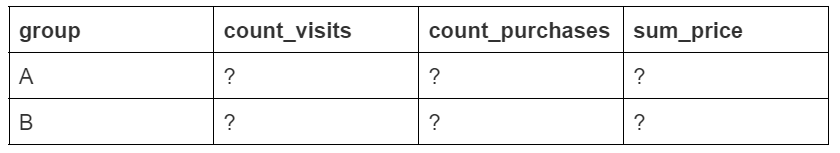
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [14]:
updated_data_grouped = updated_data[["user_id", "purchase", "price", "group"]].groupby("group").agg({
    "user_id": "count",
    "purchase": "sum",
    "price": "sum"
}).reset_index().rename(columns={'user_id': 'count_visits', 
                                 'purchase': 'count_purchases', 
                                 'price': 'sum_price'})
updated_data_grouped.head()

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

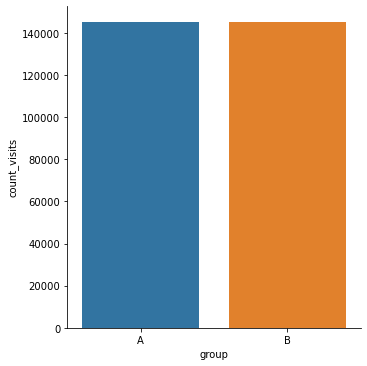

In [15]:
sns.catplot(kind="bar", x="group", y="count_visits", data=updated_data_grouped)

Нет статистически-значимой разницы в количестве посещений для обоих групп. Можно считать, что выборка сбалансирована. 

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [16]:
updated_data_grouped["conversion"] = round(updated_data_grouped["count_purchases"] / updated_data_grouped["count_visits"] * 100, 2)
updated_data_grouped["mean_check"] = round(updated_data_grouped["sum_price"] / updated_data_grouped["count_purchases"])

In [17]:
updated_data_grouped

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,81076.0
1,B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Вариан А эффективнее варианта В по по показателю конверсии, но менее эффективен по среднему чеку

По значению конверсии нет статистически значимой разницы, эффективность, по этому показателю, одинаковая. А вот средний чек в группе В больше, следовательно, эффективность по этому показателю выше.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [26]:
pivot_t = updated_data.pivot_table(
    'user_id',
    index='price',
    columns='group',
    aggfunc='count'
)
pivot_t

group,A,B
price,,
0,127820,128091
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

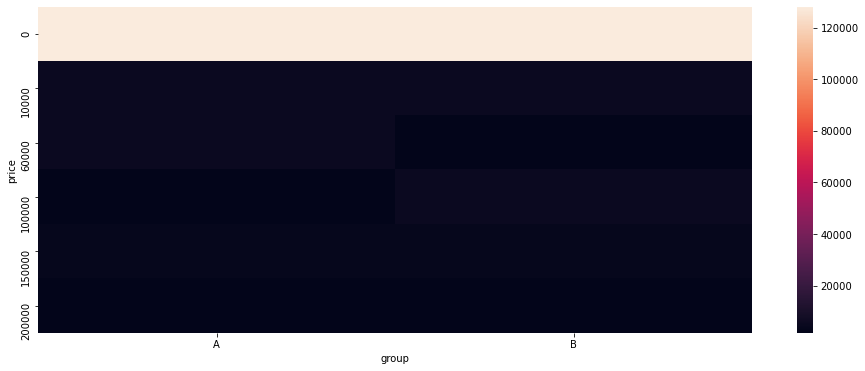

In [27]:
fig, axes = plt.subplots(figsize=(16, 6))
heat_map_yes = sns.heatmap(pivot_t, ax=axes)

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

покупательская способность участников группы А выше, чем участников группы B по туру 60000 тр

покупательская способность участников группы В выше, чем участников группы А по туру 100000 тр

Для остальных туров нет статистически-значимой разницы, чтобы принять ее во нимание

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [40]:
updated_date_data_grouped = updated_data[["user_id", "purchase", "price", "group", "date"]].groupby(["group", "date"]).agg({
    "user_id": "count",
    "purchase": "sum",
    "price": "sum"
}).reset_index().rename(columns={'user_id': 'count_visits', 
                                 'purchase': 'count_purchases', 
                                 'price': 'sum_price'})
updated_date_data_grouped.head()

,group,date,count_visits,count_purchases,sum_price
0,A,2021-01-02,2854,359,29410000
1,A,2021-01-03,6596,748,62000000
2,A,2021-01-04,6566,799,64250000
3,A,2021-01-05,6433,790,64550000
4,A,2021-01-06,6606,764,63410000


In [51]:
updated_date_data_grouped["daily_conversion"] = round(updated_date_data_grouped["count_purchases"] / updated_date_data_grouped["count_visits"] * 100, 2)
updated_date_data_grouped["mean_chek"] = round(updated_date_data_grouped["sum_price"] / updated_date_data_grouped["count_purchases"])

In [52]:
updated_date_data_grouped[updated_date_data_grouped["date"] == "2021-01-03"]

,group,date,count_visits,count_purchases,sum_price,daily_conversion,mean_chek
1,A,2021-01-03,6596,748,62000000,11.34,82888.0
24,B,2021-01-03,6619,754,65960000,11.39,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [82]:
updated_date_data_grouped["cum_count_visits"] = updated_date_data_grouped.groupby(["group"])["count_visits"].cumsum()
updated_date_data_grouped["cum_count_purchases"] = updated_date_data_grouped.groupby(["group"])["count_purchases"].cumsum()
updated_date_data_grouped["cum_sum_price"] = updated_date_data_grouped.groupby(["group"])["sum_price"].cumsum()

In [87]:
updated_date_data_grouped["cum_conversion"] = round(updated_date_data_grouped["cum_count_purchases"] / updated_date_data_grouped["cum_count_visits"] * 100, 2)
updated_date_data_grouped["cum_mean_chek"] = round(updated_date_data_grouped["cum_sum_price"] / updated_date_data_grouped["cum_count_purchases"])

In [88]:
updated_date_data_grouped[updated_date_data_grouped["date"] == "2021-01-20"]

,group,date,count_visits,count_purchases,sum_price,daily_conversion,mean_chek,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conversion,cum_mean_chek
18,A,2021-01-20,6533,749,58710000,11.46,78385.0,121506,14561,1179590000,11.98,81010.0
41,B,2021-01-20,6685,790,69250000,11.82,87658.0,121857,14496,1286900000,11.90,88776.0


In [89]:
updated_date_data_grouped[updated_date_data_grouped["date"] == "2021-01-12"]

,group,date,count_visits,count_purchases,sum_price,daily_conversion,mean_chek,cum_count_visits,cum_count_purchases,cum_sum_price,cum_conversion,cum_mean_chek
10,A,2021-01-12,6540,795,68460000,12.16,86113.0,68852,8198,668070000,11.91,81492.0
33,B,2021-01-12,6635,807,70560000,12.16,87435.0,69251,8236,727670000,11.89,88352.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

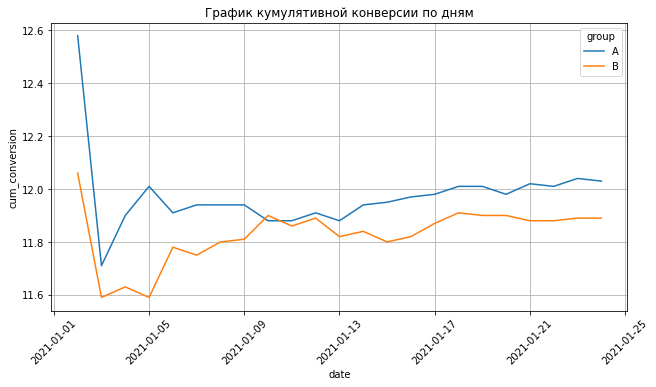

In [90]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([1, 1, 1, 1])
sns.lineplot(x='date', y='cum_conversion', data=updated_date_data_grouped, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation = 45)
ax.grid(True)

A/B-тест можно считать завершенным - значения стабилизировались. Кумулятивные показатели в группе А стабильно выше.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [100]:
converted_piv= updated_date_data_grouped.groupby('group')['cum_conversion'].agg(
    ['sum', 'count']
)
converted_piv

,sum,count
group,,
A,275.42,23
B,272.06,23


In [102]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше чем конверсия в группе B'

alpha = 0.05

_, p_value = proportions_ztest(
    count=converted_piv['count'], 
    nobs=converted_piv['sum'], 
    alternative='larger',
)

print('p-value: ', p_value)

if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.5173455708986385
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

По результату теста можно сказать, что нет статистически-значимой разницы между конверсиями в группах А и B

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [111]:
def conversion_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 
    lower_bound = x_p - eps 
    upper_bound = x_p + eps 
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [112]:

def diff_conversion_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma
    diff = xp[1] - xp[0]
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5
    lower_bound = diff - eps
    upper_bound = diff + eps 
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [113]:
a_data = updated_data[updated_data['group'] == 'A']
b_data = updated_data[updated_data['group'] == 'B']
conf_interval_a = conversion_conf_interval(
a_data['user_id'].count(), 
a_data['purchase'].mean()
)
conf_interval_b = conversion_conf_interval(
b_data['user_id'].count(),
b_data['purchase'].mean()
)
print(f'Доверительный интервал для группы А: {conf_interval_a}')
print(f'Доверительный интервал для группы B: {conf_interval_b}')


n = [a_data['user_id'].count(), b_data['user_id'].count()]
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]

diff_inverval = diff_conversion_conf_interval(n, xp)
print(f'Доверительный интервал для разности конверсий: {diff_inverval}') 

Доверительный интервал для группы А: (11.87, 12.2)
Доверительный интервал для группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Перекрытие между доверительными интервалами есть.
Статистически-значимой разницы между конверсиями в группах А и B нет.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [107]:
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 
 
updated_date_data_grouped_A = updated_date_data_grouped[updated_date_data_grouped['group'] == 'A']
updated_date_data_grouped_B = updated_date_data_grouped[updated_date_data_grouped['group'] == 'B']
 

shapiro_result_A = shapiro(updated_date_data_grouped_A['mean_chek'])
shapiro_result_B = shapiro(updated_date_data_grouped_B['mean_chek'])
print('p-value группы А', round(shapiro_result_A.pvalue, 2))
print('p-value группы B', round(shapiro_result_B.pvalue, 2))

if shapiro_result_A.pvalue < alpha or shapiro_result_B.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [110]:
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05
 
updated_date_data_grouped_A = updated_date_data_grouped[updated_date_data_grouped['group'] == 'A']
updated_date_data_grouped_B = updated_date_data_grouped[updated_date_data_grouped['group'] == 'B']
 
#вычисляем результат T-теста для выборок
results = ttest_ind(
    updated_date_data_grouped_A['mean_chek'],
    updated_date_data_grouped_B['mean_chek'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

По результатам теста можно сделать вывод, что необходимо учитывать разницу между ежедневными средними чеками в группах А и B

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [115]:
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1
    alpha = 1 - gamma
    t_crit = -t.ppf(alpha/2, k)
    eps = t_crit * x_std / n**0.5
    lower_bound = x_mean - eps
    upper_bound = x_mean + eps
    return round(lower_bound), round(upper_bound)


In [116]:

updated_date_data_grouped_A = updated_date_data_grouped[updated_date_data_grouped['group'] == 'A']
updated_date_data_grouped_B = updated_date_data_grouped[updated_date_data_grouped['group'] == 'B']
 
params_a = {
    'n': updated_date_data_grouped_A['count_visits'].count(), # размер выборки
    'x_mean': updated_date_data_grouped_A['mean_chek'].mean(), # выборочное средние
    'x_std': updated_date_data_grouped_A['mean_chek'].std() # выборочное стандартное отклонения
}
params_b = {
    'n': updated_date_data_grouped_B['count_visits'].count(),# размер выборки
    'x_mean': updated_date_data_grouped_B['mean_chek'].mean(), # выборочное средние
    'x_std': updated_date_data_grouped_B['mean_chek'].std() # выборочное стандартное отклонения
}
 
print('Доверительный интервал для среднего чека группы А: {}'.format(mean_check_conf_interval(**params_a))) 
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_check_conf_interval(**params_b)))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Пересечений между доверительными интервалами нету.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

По значению конверсии вариант В не имеет статистически-значимой эффективности в сравнении с вариантом А, однако по значению среднего чека его эффективность выше.